### Курсовой проект по курсу "Библиотеки Python для Data Science, часть 1" <a class="anchor" id="chapter1"></a>

##### Никнейм на Kaggle: MyNegative

### Содержание:
* [Начало работы](#chapter1)
    * [Загрузка модулей и библиотек](#section_1_1)
    * [Загрузка данных](#section_1_2)
* [Работа с тренировочным датасетом](#chapter2)
    * [Гипотезы, предположения и то, с чем хорошо бы поработать](#section_2_1)
    * [Floor > HouseFloor](#section_2_2)
    * [Странная комнатность](#section_2_3)
    * [Год постройки дома](#section_2_4)
    * [Жилая площадь (LifeSquare) и площадь (Square) квартиры](#section_2_5)
    * [Нестандартные кухни](#section_2_6)
    * [Общая площадь](#section_2_7)
    * [Социальные признаки](#section_2_8)
    * [Здравоохранение](#section_2_9)
    * [Создание новых признаков](#section_2_10)
* [DataPipeLine](#chapter3)
* [Построение модели](#chapter4)
    * [Предсказание](#section_4_1)

Загрузка модулей и библиотек <a class="anchor" id="section_1_1"></a>

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Загрузка данных <a class="anchor" id="section_1_2"></a>

In [2]:
path_to_train = './train.csv'
path_to_test = './test.csv'

In [3]:
training = pd.read_csv(path_to_train)
testing = pd.read_csv(path_to_test)
nulls = pd.DataFrame({'Train': training.isna().sum(), 'Test': testing.isna().sum()})
nulls

,Train,Test
DistrictId,0,0.0
Ecology_1,0,0.0
Ecology_2,0,0.0
Ecology_3,0,0.0
Floor,0,0.0
Healthcare_1,4798,2377.0
Helthcare_2,0,0.0
HouseFloor,0,0.0
HouseYear,0,0.0
Id,0,0.0


В обоих датасетах - тренировочном и тестовом - всего два признака (причем одни и те же) с пропусками, что значительно упрощает жизнь и дальнейшую работу

### Работа с тренировочным датасетом <a class="anchor" id="chapter2"></a>

*Поскольку после консультации по курсовому проекту оказалось, что достаточно значительную часть работы мне нужно переделать полностью, а времени оставалось не так много, ограничусь кратким описанием проведенной работы*

Распределение целевой переменной вполне нормальное

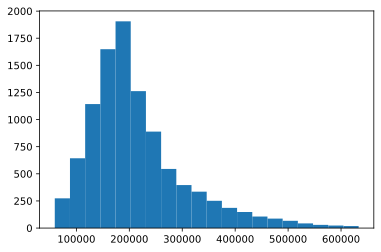

In [4]:
training['Price'].hist(bins=20, grid=False)
plt.show()

Прежде чем начать работу с пропусками и выбросами, посмотрим на логику в данных и найдем странные значения

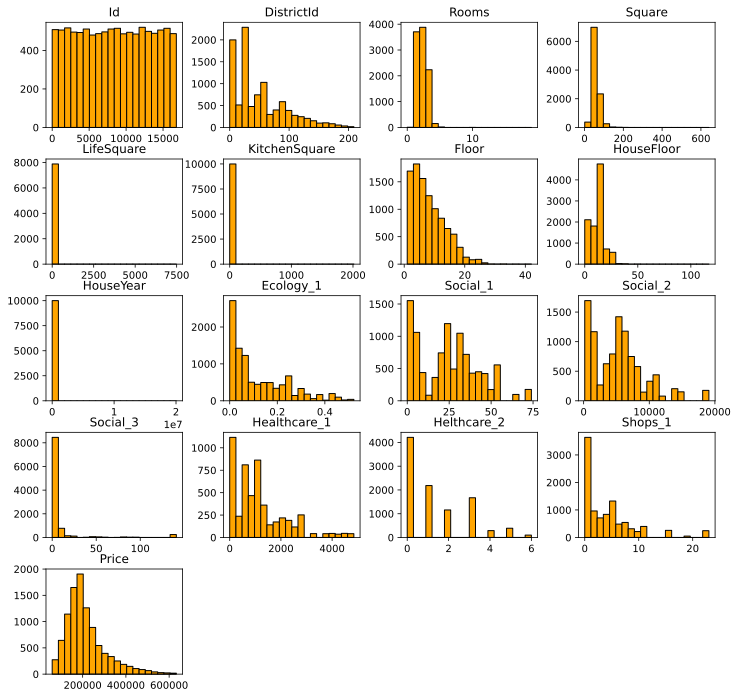

In [5]:
training.hist(figsize=(12, 12), bins=20, grid=False, color='orange', ec='black')
plt.show()

In [6]:
training.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Гипотезы, предположения и то, с чем хорошо бы поработать: <a class="anchor" id="section_2_1"></a>
1. Проверка Floor (этаж) > HouseFloor (количество этажей в доме)
2. Проверка комнатности (Rooms) и поиск странных значений
3. Год постройки дома
4. Необычные значения LifeSquare, Square и KitchenSquare
5. Два социальных признака > 100

#### Floor > HouseFloor <a class="anchor" id="section_2_2"></a>

Метод describe показал необычные значения этажей (например, больше 50). Кроме того, в датасете есть ряд записей, где Floor превышает HouseFloor, и в этом случае заменим такие значения Floor на рандомное число от 1 до HouseFloor

In [7]:
training.loc[training['HouseFloor'] == 0, 'HouseFloor'] = training.loc[training['HouseFloor'] == 0, 'Floor']
training.loc[training['HouseFloor'] > 70, 'HouseFloor'] = training.loc[training['HouseFloor'] > 70, 'HouseFloor'] // 10
        
mask = (training['Floor'] > training['HouseFloor'])
training.loc[mask, 'Floor'] = np.random.randint(1, training.loc[mask, 'HouseFloor'] + 1)

#### Странная комнатность <a class="anchor" id="section_2_3"></a>

Датасет содержит записи, где число комнат = 0, 6, от 10 и больше. Решение: оставить максимальное количество комнат = 5, а выбивающиеся значения заменить медианой

In [8]:
training.loc[(training['Rooms'] == 6) | (training['Rooms'] >= 10) | (training['Rooms'] == 0), 'Rooms'] =\
    int(training['Rooms'].median())

#### Год постройки дома <a class="anchor" id="section_2_4"></a>

В случаях, когда год постройки дома > 2020, заменим эти значения на 2020-й

In [9]:
training.loc[training['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Жилая площадь (LifeSquare) и площадь (Square) квартиры <a class="anchor" id="section_2_5"></a>

Действие 1: *Посчитать среднюю долю жилой площади от общей площади и заменить числом Square * living_share все записи, где LifeSquare > Square*

Действие 2: *Принять за данность, что жилая площадь не может быть меньше 9 кв.м.*

Действие 3: *Посчитать медианное значение свободной площади (коридоров, балкона, ванной комнаты, etc.) и заменить с помощью разницы Square - KitchenSquare - spare_med все пропуски в LifeSquare*

In [10]:
living_share = (training['LifeSquare'] / training['Square']).mean()
training.loc[training['LifeSquare'] > training['Square'], 'LifeSquare'] = \
    training.loc[training['LifeSquare'] > training['Square'], 'Square'] * living_share
        
training.loc[training['LifeSquare'] < 9, 'LifeSquare'] = 9
        
spare_med = (training.loc[training['Square'].notnull(), 'Square'] -\
        training.loc[training['LifeSquare'].notnull(), 'LifeSquare'] -\
        training.loc[training['KitchenSquare'].notnull(), 'KitchenSquare']).median()
        
training.loc[training['LifeSquare'].isnull(), 'LifeSquare'] =\
    training.loc[training['LifeSquare'].isnull(), 'Square'] -\
    training.loc[training['LifeSquare'].isnull(), 'KitchenSquare'] -\
    spare_med

#### Нестандартные кухни <a class="anchor" id="section_2_6"></a>

Повторить действия, аналогичные действиям из предыдущей секции, но с KitchenSquare и чуть-чуть подправить LifeSquare. За минимальную площадь кухни возьмем 5 кв.м., так как, согласно СНиП (Строительным нормам и правилам Российской Федерации), площадь кухонной зоны в зоне-столовой не должна быть меньше 6 кв.м. в квартирах социального использования государственного и муниципального жилищных фондов. Коммерческое жилье допускает площадь не менее 5 кв.м. Хотя не до конца известно, что этот датасет про Россию, но цифра хорошая.

In [11]:
kitchen_share = (training['KitchenSquare'] / training['Square']).mean()
training.loc[training['KitchenSquare'] > training['Square'], 'KitchenSquare'] =\
    training.loc[training['KitchenSquare'] > training['Square'], 'Square'] * kitchen_share
        
training.loc[training['KitchenSquare'] < 5, 'KitchenSquare'] = np.random.randint(5, 12)
        
training.loc[training['LifeSquare'] < 9, 'KitchenSquare'] =\
    training.loc[training['LifeSquare'] < 9, 'Square'] * kitchen_share
        
training.loc[training['LifeSquare'] < 9, 'LifeSquare'] = 9

#### Общая площадь <a class="anchor" id="section_2_7"></a>

Повторим те же самые действия, что и в предыдущих двух секциях, но для тех оставшихся случаев, где общая площадь по-прежнему остается меньше жилой площади и дает отрицательное значение при вычитании LifeSquare, KitchenSquare и медианы свободного пространства

In [12]:
training.loc[training['LifeSquare'] > training['Square'], 'Square'] =\
    training.loc[training['LifeSquare'] > training['Square'], 'LifeSquare'] +\
    training.loc[training['LifeSquare'] > training['Square'], 'KitchenSquare'] +\
    spare_med
        
training.loc[training['Square'] < training['LifeSquare'] + training['KitchenSquare'], 'LifeSquare'] =\
    training.loc[training['Square'] < training['LifeSquare'] + training['KitchenSquare'], 'Square'] * living_share
        
training.loc[training['Square'] < training['LifeSquare'] + training['KitchenSquare'], 'KitchenSquare'] =\
    training.loc[training['Square'] < training['LifeSquare'] + training['KitchenSquare'], 'Square'] * kitchen_share

#### Социальные признаки <a class="anchor" id="section_2_8"></a>

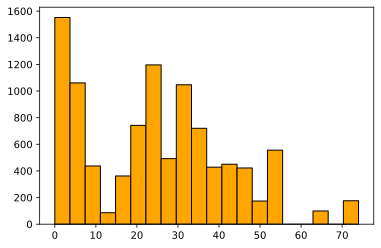

In [13]:
training['Social_1'].hist(bins=20, color='orange', ec='black', grid=False)
plt.show()

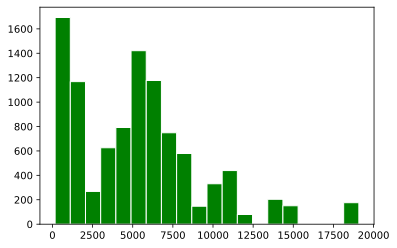

In [14]:
training['Social_2'].hist(bins=20, color='green', ec='white', grid=False)
plt.show()

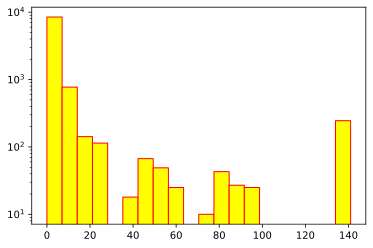

In [15]:
training['Social_3'].hist(bins=20, color='yellow', ec='red', grid=False, log=True)
plt.show()

Гистограммы признаков Social_1 и Social_3 говорят о том, что при оценке, вероятнее всего, использовалась 100-балльная шкала, а значит в Social_3 есть очевидный выброс > 100, что, скорее всего, является ошибкой (лишняя сотня), поскольку значений немного

In [16]:
training.loc[training['Social_3'] > 100, 'Social_3'] = training.loc[training['Social_3'] > 100, 'Social_3'] // 10
training.loc[training['Social_1'] > 100, 'Social_1'] = training.loc[training['Social_1'] > 100, 'Social_3'] // 10

#### Здравоохранение <a class="anchor" id="section_2_9"></a>

Заполним пропуски средним значением признака Healthcare_1 в зависимости от района, а оставшиеся - медианой

In [17]:
health = training.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
training.loc[training['Healthcare_1'].isna(), 'Healthcare_1'] = training['DistrictId'].map(health)
        
training['Healthcare_1'].fillna(training['Healthcare_1'].median(), inplace=True)

#### Создание новых признаков <a class="anchor" id="section_2_10"></a>

Плотность предложения квартир в зависимости от района (в дальнейшем данные тренировочного и тестового датасетов будут объединяться)

In [18]:
density = training['DistrictId'].value_counts().to_dict()
training['DistrictSize'] = training['DistrictId'].map(density)

Величина района

In [19]:
training['IsLarge'] = 0
training.loc[training['DistrictSize'] > 400, 'IsLarge'] = 1

Возраст дома

In [20]:
training['House_Age'] = datetime.now().year - training['HouseYear']

Создадим dummies для категориальных признаков Ecology_2, Ecology_3 и Shops_2

In [21]:
training = pd.get_dummies(training)

### Класс DataPipeLine: <a class="anchor" id="chapter3"></a>

In [22]:
class DataPipeLine:
    
    def __init__(self):
        self.mask = None
        self.rooms = None
        self.health = None
        self.living_share = None
        self.kitchen_share = None
        self.spare_med = None
        self.min_square = None
        
    def cleaning(self, df):
        
        #Работа с этажностью
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df.loc[df['HouseFloor'] == 0, 'Floor']
        df.loc[df['HouseFloor'] > 70, 'HouseFloor'] = df.loc[df['HouseFloor'] > 70, 'HouseFloor'] // 10
        
        self.mask = (df['Floor'] > df['HouseFloor'])
        df.loc[self.mask, 'Floor'] = np.random.randint(1, df.loc[self.mask, 'HouseFloor'] + 1)
        
        #Работа с комнатами
        df.loc[(df['Rooms'] == 6) | (df['Rooms'] >= 10) | (df['Rooms'] == 0), 'Rooms'] = int(df['Rooms'].median())
        
        #Работа с годом постройки дома
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        #Работа с жилой площадью
        self.living_share = (df['LifeSquare'] / df['Square']).mean()
        df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = \
            df.loc[df['LifeSquare'] > df['Square'], 'Square'] * self.living_share
        
        df.loc[df['LifeSquare'] < 9, 'LifeSquare'] = 9
        
        self.spare_med = (df.loc[df['Square'].notnull(), 'Square'] -\
                     df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -\
                     df.loc[df['KitchenSquare'].notnull(), 'KitchenSquare']).median()
        
        df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] =\
            df.loc[df['LifeSquare'].isnull(), 'Square'] -\
            df.loc[df['LifeSquare'].isnull(), 'KitchenSquare'] -\
            self.spare_med
                    
        #Работа с кухнями
        self.kitchen_share = (df['KitchenSquare'] / df['Square']).mean()
        df.loc[df['KitchenSquare'] > df['Square'], 'KitchenSquare'] =\
            df.loc[df['KitchenSquare'] > df['Square'], 'Square'] * self.kitchen_share
        
        df.loc[df['KitchenSquare'] < 5, 'KitchenSquare'] = np.random.randint(5, 12)
        
        df.loc[df['LifeSquare'] < 9, 'KitchenSquare'] =\
            df.loc[df['LifeSquare'] < 9, 'Square'] * self.kitchen_share
        
        df.loc[df['LifeSquare'] < 9, 'LifeSquare'] = 9
        
        #Работа с общей площадью
        df.loc[df['LifeSquare'] > df['Square'], 'Square'] =\
            df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] +\
            df.loc[df['LifeSquare'] > df['Square'], 'KitchenSquare'] +\
            self.spare_med
        
        df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'LifeSquare'] =\
            df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'Square'] * self.living_share
        
        df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'KitchenSquare'] =\
            df.loc[df['Square'] < df['LifeSquare'] + df['KitchenSquare'], 'Square'] * self.kitchen_share
                    
        #Поправка социальных признаков
        df.loc[df['Social_3'] > 100, 'Social_3'] = df.loc[df['Social_3'] > 100, 'Social_3'] // 10
        df.loc[df['Social_1'] > 100, 'Social_1'] = df.loc[df['Social_1'] > 100, 'Social_3'] // 10
        
        #Работа с Healthcare_1
        self.health = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.health)
        
        df['Healthcare_1'].fillna(df['Healthcare_1'].median(), inplace=True)
        
        return df
    
    def features(self, train, test):
        
        #Количество домов в районе
        area = pd.concat([train, test], ignore_index=True)
        district_size = area['DistrictId'].value_counts().to_dict()
        train['DistrictSize'] = train['DistrictId'].map(district_size)
        test['DistrictSize'] = test['DistrictId'].map(district_size)
        
        #Крупный район
        train['IsLarge'] = 0
        train.loc[train['DistrictSize'] > 400, 'IsLarge'] = 1
        test['IsLarge'] = 0
        test.loc[test['DistrictSize'] > 400, 'IsLarge'] = 1
        
        #Новый признак - возраст дома
        train['House_Age'] = datetime.now().year - train['HouseYear']
        test['House_Age'] = datetime.now().year - test['HouseYear']
        
        #Категориальные признаки
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        
        return train, test

In [23]:
pipe = DataPipeLine()
train = pd.read_csv(path_to_train)
train = pipe.cleaning(train)

test = pd.read_csv(path_to_test)
test = pipe.cleaning(test)

train, test = pipe.features(train, test)

### Построение модели <a class="anchor" id="chapter4"></a>

In [24]:
X = train.drop(labels=['Id', 'DistrictId', 'Price'], axis=1)
y = train['Price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=30,
                                  max_depth=5, n_estimators=200, random_state=42)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_valid)

print(f'R2 тренировочных данных: {round(r2_score(y_train, y_train_pred), 3)}')
print(f'R2 валидационных данных: {round(r2_score(y_valid, y_pred), 3)}')

R2 тренировочных данных: 0.851
R2 валидационных данных: 0.755


#### Предсказание <a class="anchor" id="section_4_1"></a>

In [25]:
id = test['Id']
test = test.drop(['Id', 'DistrictId'], axis=1)

y_test_pred = model.predict(test)

result = pd.DataFrame({
    'Price': y_test_pred.flatten()}, index=id)

result.head(10)

,Price
Id,
4567,166933.870083
5925,125005.651006
960,144651.985081
3848,90419.915693
746,193060.135968
868,333607.579664
672,110677.228821
2471,204465.417794
4510,138320.460181


In [26]:
#result.to_csv('result.csv')